In [1]:
!rm -r *
!git clone https://github.com/LudoRey/dip-deblur/
!mv dip-deblur/* ./
!rm -r dip-deblur

Cloning into 'dip-deblur'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 105 (delta 50), reused 67 (delta 23), pack-reused 0
Receiving objects: 100% (105/105), 1.66 MiB | 21.26 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [2]:
import torch
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from unet import *
from utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

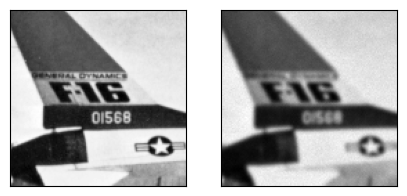

In [19]:
# Read image and create degraded version

im = read_img('data/airplane.tif', as_tensor=True).to(device)
ker = gaussian_kernel(sigma=1.2, as_tensor=True).to(device)

im_blur = blur(im, ker)
im_blur_noisy = poisson_noise(im_blur, peak=5e3)

fig, axes = plt.subplots(1,2, figsize=(5,10))
axes[0].imshow(to_numpy(im), cmap='gray')
axes[1].imshow(to_numpy(im_blur_noisy), cmap='gray')
for ax in axes:
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()

In [20]:
nb_epoch = 1000
learning_rate = 0.01
input = (torch.rand(1,32,128,128)/10).to(device)
criterions = [nn.MSELoss(), CsiszarDiv()]

net_params = {'feature_channels' : 128, 'skip_channels' : 4, 'depth' : 4}

all_psnr = []
all_im_recon = []

for i_run in range(2):
    im_blur_noisy = im_blur_noisy
    criterion = criterions[i_run]
    # Create network
    model = Unet(in_channels=input.shape[1], out_channels=1, **net_params)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Optimizing loop
    model.train()
    for i_epoch in range(nb_epoch):
        optimizer.zero_grad()
        im_recon = model(input)
        loss = criterion(blur(im_recon, ker), im_blur_noisy)
        loss.backward()
        optimizer.step()
        if (i_epoch+1) % 100 == 0:
            metric = psnr(to_numpy(im), to_numpy(im_recon))
            print(' [-] Run {:} epoch {:}/{:}, loss {:.6f}, psnr {:.5f}'.format(i_run, i_epoch+1, nb_epoch, loss.item(), metric))
    all_psnr.append(psnr(to_numpy(im), to_numpy(im_recon)))
    all_im_recon.append(to_numpy(im_recon))

 [-] Run 0 epoch 100/1000, loss 0.000714, psnr 24.55675
 [-] Run 0 epoch 200/1000, loss 0.000191, psnr 27.91469
 [-] Run 0 epoch 300/1000, loss 0.000158, psnr 28.94223
 [-] Run 0 epoch 400/1000, loss 0.000126, psnr 29.55005
 [-] Run 0 epoch 500/1000, loss 0.000117, psnr 29.90923
 [-] Run 0 epoch 600/1000, loss 0.000200, psnr 29.66119
 [-] Run 0 epoch 700/1000, loss 0.000109, psnr 30.27901
 [-] Run 0 epoch 800/1000, loss 0.000106, psnr 30.42816
 [-] Run 0 epoch 900/1000, loss 0.000104, psnr 30.53394
 [-] Run 0 epoch 1000/1000, loss 0.000103, psnr 30.54782
 [-] Run 1 epoch 100/1000, loss 33.218361, psnr 22.62807
 [-] Run 1 epoch 200/1000, loss 4.177910, psnr 27.44502
 [-] Run 1 epoch 300/1000, loss 2.369990, psnr 29.01824
 [-] Run 1 epoch 400/1000, loss 1.948124, psnr 29.70078
 [-] Run 1 epoch 500/1000, loss 1.773565, psnr 30.08975
 [-] Run 1 epoch 600/1000, loss 1.683526, psnr 30.33111
 [-] Run 1 epoch 700/1000, loss 1.791946, psnr 30.42089
 [-] Run 1 epoch 800/1000, loss 1.580115, psnr

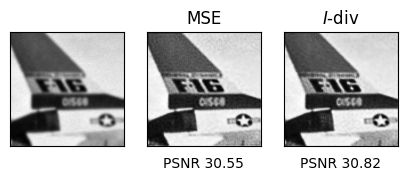

In [27]:
fig, axes = plt.subplots(1,3, figsize=(5,10))
axes[1].set_title(r'MSE')
axes[2].set_title(r'$I$-div')
axes[0].imshow(to_numpy(im_blur_noisy), cmap='gray')
for j in range(2):
  axes[j+1].imshow(all_im_recon[j], cmap='gray')
  axes[j+1].set_xlabel('PSNR {:.2f}'.format(all_psnr[j]))
for ax in axes.flatten():
  ax.tick_params(axis=u'both', which=u'both',length=0)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  
plt.show()
fig.savefig('figs/poisson.png', dpi=300, bbox_inches='tight', transparent=True)